In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
filepath = f'fake reviews dataset.csv'
df = pd.read_csv(filepath)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['review'] = df['text_'].apply(preprocess_text)
X = df['review']
y = df['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
 # Encode labels (Convert 'CG', 'OR' to numbers)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert 'CG', 'OR' to numbers
y_test_encoded = label_encoder.transform(y_test)  # Convert test labels too

In [5]:
# Vectorize the text data (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4016
           1       0.87      0.89      0.88      4071

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087

Logistic Regression Confusion Matrix:
[[3491  525]
 [ 433 3638]]


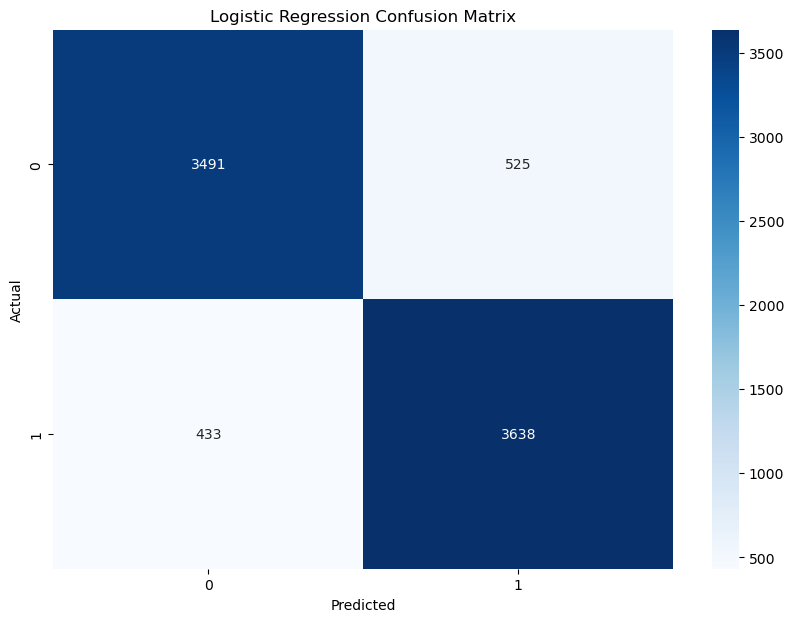

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4016
           1       0.88      0.92      0.90      4071

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087

SVM Confusion Matrix:
[[3528  488]
 [ 345 3726]]


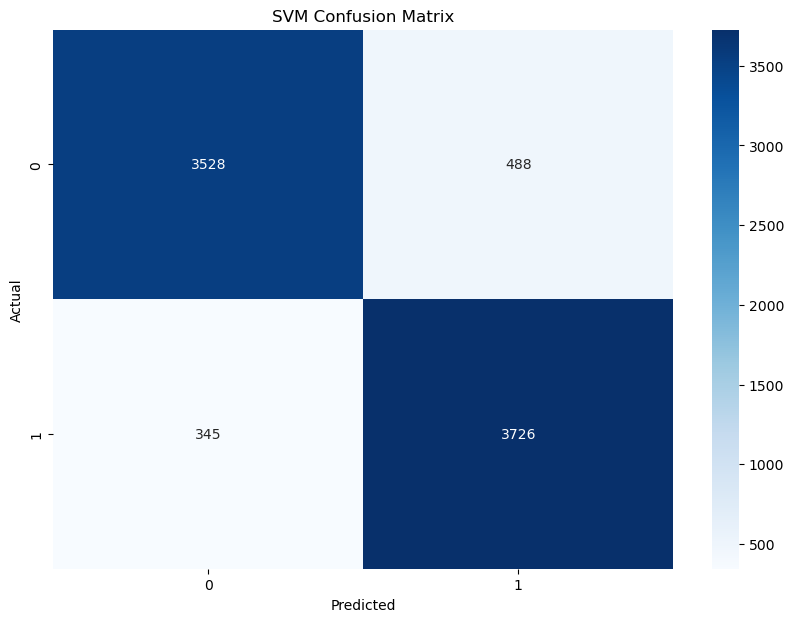

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4016
           1       0.88      0.81      0.84      4071

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Random Forest Confusion Matrix:
[[3555  461]
 [ 767 3304]]


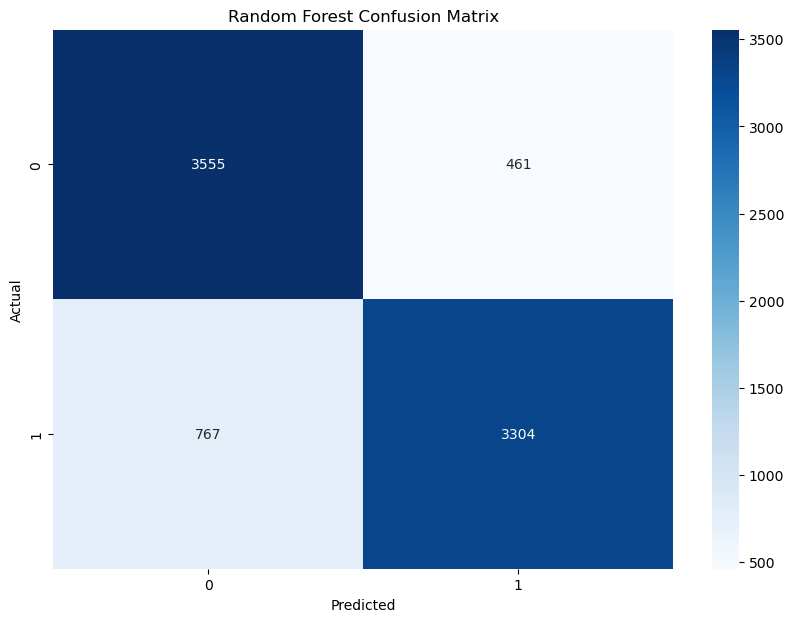

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4016
           1       0.84      0.88      0.86      4071

    accuracy                           0.86      8087
   macro avg       0.86      0.86      0.86      8087
weighted avg       0.86      0.86      0.86      8087

XGBoost Confusion Matrix:
[[3321  695]
 [ 476 3595]]


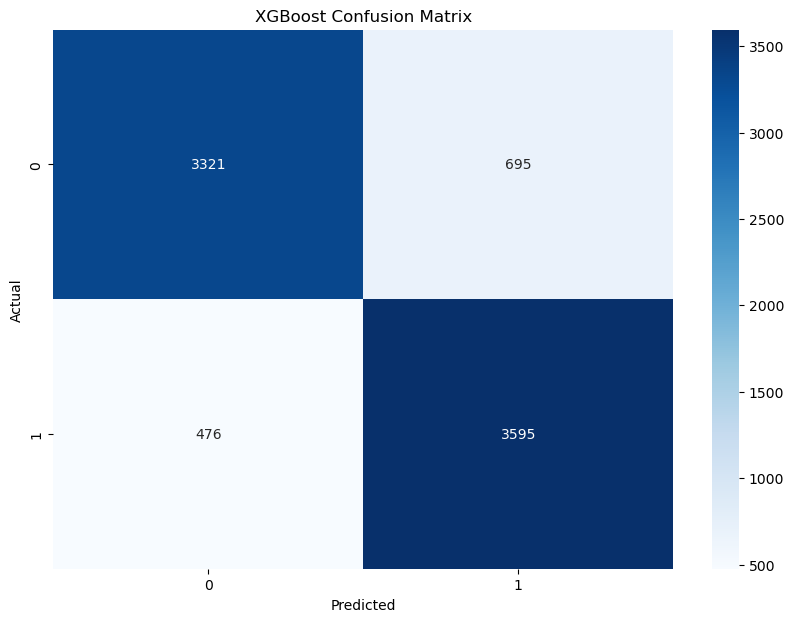

In [6]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Models to evaluate
    models = {
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }

    accuracies = {}

    for model_name, model in models.items():
        model.fit(X_train_tfidf, y_train_encoded)  # Use the encoded labels
        y_pred = model.predict(X_test_tfidf)
        accuracies[model_name] = accuracy_score(y_test_encoded, y_pred)  # Compare with encoded test labels

        print(f'{model_name} Classification Report:\n{classification_report(y_test_encoded, y_pred)}')  # Use encoded labels
        cm = confusion_matrix(y_test_encoded, y_pred)  # Use encoded labels
        print(f'{model_name} Confusion Matrix:\n{cm}')
        plot_confusion_matrix(cm, model_name)

    return accuracies

model_accuracies = train_and_evaluate_models(X_train, X_test, y_train, y_test)

In [7]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.FloatTensor(X_train_tfidf.toarray()).to(device)
X_test_tensor = torch.FloatTensor(X_test_tfidf.toarray()).to(device)
# Convert y_train and y_test to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now create the tensors
y_train_tensor = torch.FloatTensor(y_train_encoded).to(device)
y_test_tensor = torch.FloatTensor(y_test_encoded).to(device)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=250, num_layers=1): # Changed _init_ to __init__
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Reshape input for LSTM [batch_size, seq_length, input_size]
        x = x.unsqueeze(1)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze()

In [8]:
model = LSTMModel(input_size=X_train_tfidf.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 10
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

torch.save(model.state_dict(), 'lstm_model_pytorch.pth')

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = (test_outputs > 0.5).float()
    accuracy = (predictions == y_test_tensor).float().mean()
    print(f'Test Accuracy: {accuracy:.4f}')

Epoch [1/10], Loss: 0.3841
Epoch [2/10], Loss: 0.2371
Epoch [3/10], Loss: 0.2147
Epoch [4/10], Loss: 0.2030
Epoch [5/10], Loss: 0.1947
Epoch [6/10], Loss: 0.1878
Epoch [7/10], Loss: 0.1827
Epoch [8/10], Loss: 0.1766
Epoch [9/10], Loss: 0.1716
Epoch [10/10], Loss: 0.1659
Test Accuracy: 0.8751
